# Planar data classification with one hidden layer

还是简单的神经网络。

主要目标：
1. 准备数据： 有自己生成的，也有使用 `sklearn.datasets` 生成的
2. 构建神经网络（非常简单，只有一个hidden layer，一个输出层）
3. 训练，调参，评估 accuracy

其他：
1. 生成数据过程，没仔细看
2. 画图，还是画图！！ 画边界用到了 `contourf` 这个方法

In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 1 准备数据

这里生成数据

(2, 400)
(1, 400)
[ 1.20444229  3.57611415] 0


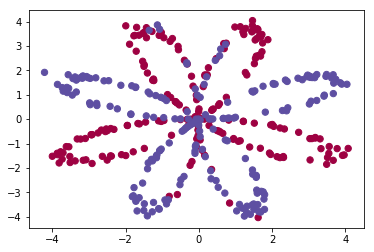

In [13]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower
    
    p = 3.12
    for j in range(2):
        ix = range(N*j, N*(j+1))
        t = np.linspace(j*p, (j+1)*p, N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X.T, Y.T

X, Y = load_planar_dataset()
print(X.shape)
print(Y.shape)
print(X[:, 0], Y[0][0])

# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);


## 2 简单 Logistic Regression


In [17]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


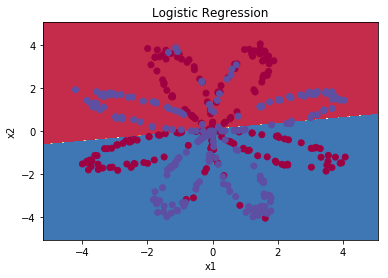

In [18]:
import sklearn.linear_model
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

## 3 - Neural Network model

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


In [36]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

class NN_model():
    def __init__(self, n_0, n_1, n_2):
        # n_0 = #features
        # n_1 = #hidden units of 1st layer
        # n_2 = #outputs
        self.initialize_parameters(n_0, n_1, n_2)
    
    def initialize_parameters(self, n_0, n_1, n_2):
        np.random.seed(2)
        self.W1 = np.random.randn(n_1, n_0) * 0.01
        self.b1 = np.zeros((n_1, 1))
        self.W2 = np.random.randn(n_2, n_1) * 0.01
        self.b2 = np.zeros((n_2, 1))
    
    def compute_loss(self, YP, Y):
        m = Y.shape[1] # number of example
        # cross-entropy
        cost = - np.sum(Y * np.log(YP) + (1 - Y) * np.log(1 - YP)) / m
        cost = np.squeeze(cost)  
        return cost
    
    def optimize(self, X, Y, learning_rate):
        # forward
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = sigmoid(Z2)   # sigmoid
        
        # backward
        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.multiply(np.dot(self.W2.T, dZ2), 1 - np.power(A1, 2))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m
        
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        
        loss = self.compute_loss(A2, Y)
        return loss
    
    def predict(self, X):
        # forward
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = sigmoid(Z2)
        predictions = (A2 > 0.5)
        return predictions
        
        

In [37]:

def train_nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    nn_model = NN_model(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        cost = nn_model.optimize(X, Y, learning_rate=1.2)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    return nn_model

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219463
Cost after iteration 9000: 0.218560
Accuracy: 90%


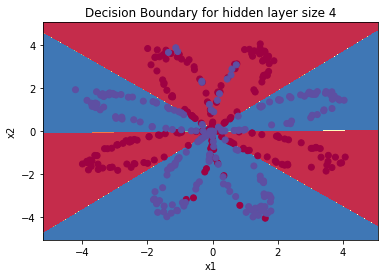

In [40]:
# Build a model with a n_h-dimensional hidden layer
model = train_nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))


predictions = model.predict(X)

print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

## 4 超参（hidden units数量）


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.25 %


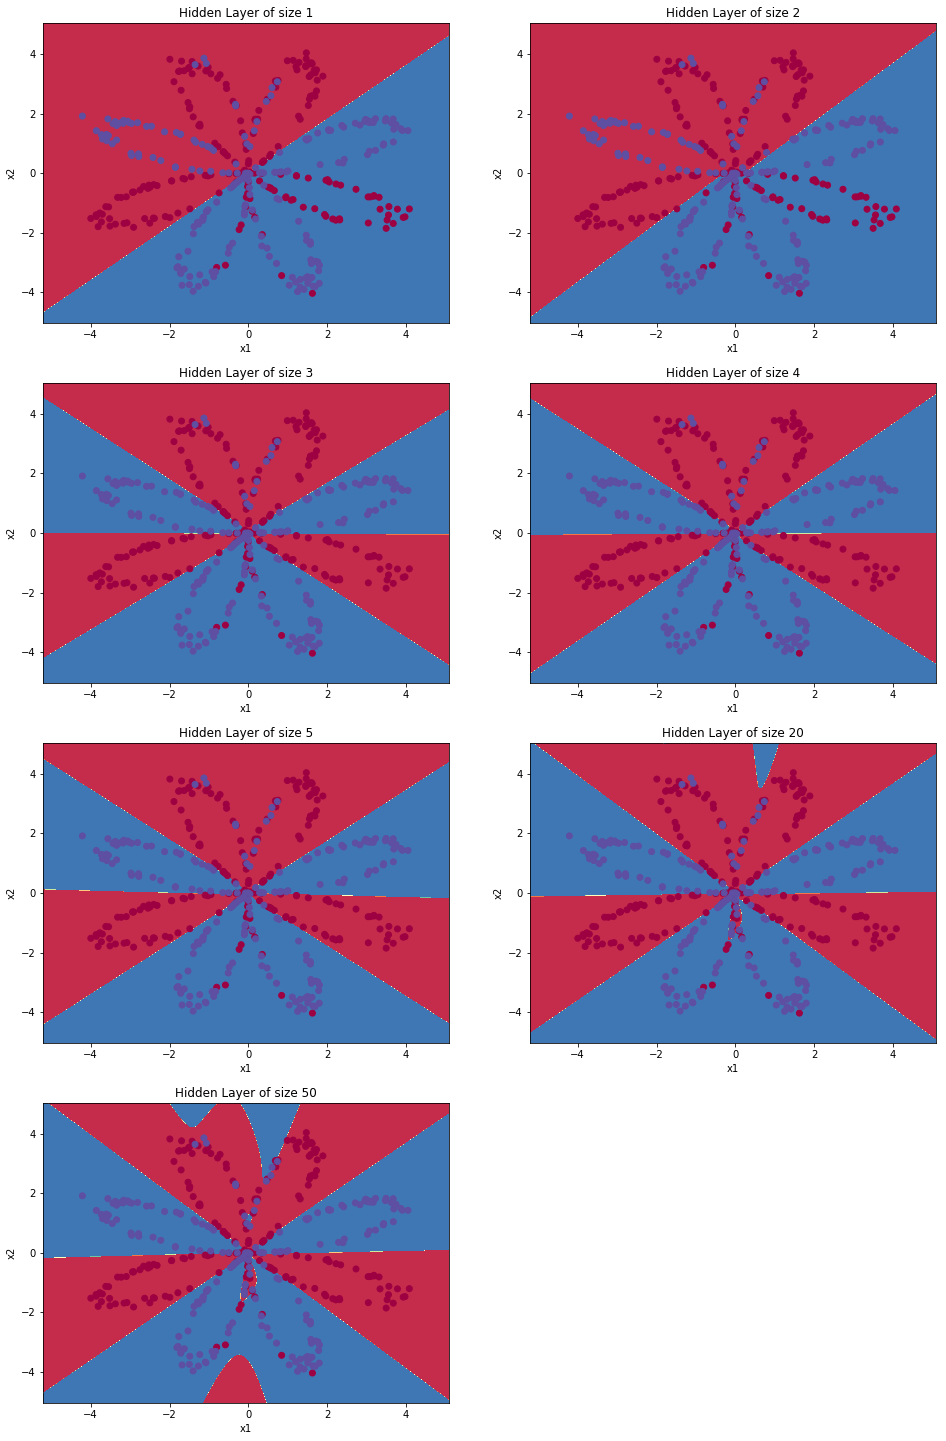

In [42]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    model = train_nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: model.predict(x.T), X, Y)
    predictions = model.predict(X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

## 5 Performance on other datasets

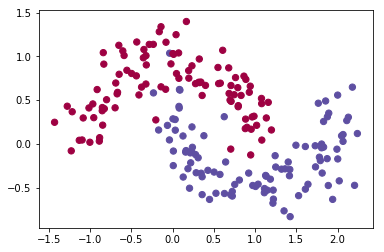

In [43]:
# Datasets
import sklearn.datasets
N = 200
noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Cost after iteration 0: 0.692992
Cost after iteration 1000: 0.281688
Cost after iteration 2000: 0.175087
Cost after iteration 3000: 0.077072
Cost after iteration 4000: 0.069491
Cost after iteration 5000: 0.065891
Cost after iteration 6000: 0.063846
Cost after iteration 7000: 0.062450
Cost after iteration 8000: 0.061382
Cost after iteration 9000: 0.060495


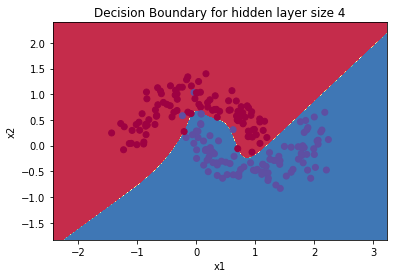

In [45]:
# Build a model with a n_h-dimensional hidden layer
model = train_nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

Congrats on finishing this Programming Assignment!

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/